In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import cv2
import pandas as pd
import argparse
import shutil
import seaborn as sns
import json
import h5py
import glob
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, accuracy_score, precision_score, recall_score
from scipy import stats

## Arglines

In [41]:
args = dict()
sample_id = "TNE0954"
ResExpRoformerFormat = "/home/mathiane/LNENWork/data_RoFormerMIL_CaA1CaA2_norm/dataRoFormer/script_analysis/unbeat_steed_2024_04_11_21-24"
FolderAttnMaps = "attn_maps_formated"
VizAttnMaps = "viz_attn_maps"
args['folder_tumoral_tiles'] ='/home/mathiane/LNENWork/Tiles_HE_all_samples_384_384_Vahadane_2'
args['folder_WSI_jpg'] =  '/home/mathiane/LNENWork/FullSlidesToJpeg'
im_size = 384

In [ ]:
os.makedirs(f'{ResExpRoformerFormat}/{VizAttnMaps}',exist_ok=True)
os.makedirs(f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA1_TruthA1',exist_ok=True)
os.makedirs(f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA2_TruthA2',exist_ok=True)
os.makedirs(f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA1_TruthA2',exist_ok=True)
os.makedirs(f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA2_TruthA1',exist_ok=True)


## Get predictions

In [4]:
df_res = pd.read_csv("/home/mathiane/LNENWork/data_RoFormerMIL_CaA1CaA2_norm/dataRoFormer/script_analysis/unbeat_steed_2024_04_11_21-24/predictions_all_test_folds.csv")

In [13]:
df_res_samples_id

,slide_id,preds,labels,probas,A1,A2,labels_names
0,TNE0954,1,1,[0.16779745 0.83220261],0.167797,0.832203,CaA2


In [12]:
df_res_samples_id = df_res[df_res["slide_id"]== sample_id]

In [25]:
attn_scores = pd.read_csv(f"{ResExpRoformerFormat}/{FolderAttnMaps}/AttnScores_{sample_id}.csv")

In [28]:
attn_scores.head()

,attn_scores_a1,attn_scores_a2,x_rank,y_rank,img_id_c,x,y,tne_id,labels_names,Probs_A1,Probs_A2,preds_roformer
0,0.000048,0.000058,0,19546,TNE0954_1_62593,1,62593,TNE0954,CaA2,0.167797,0.832203,1
1,0.000051,0.000059,1,19546,TNE0954_385_62593,385,62593,TNE0954,CaA2,0.167797,0.832203,1
2,0.000049,0.000059,2,19546,TNE0954_769_62593,769,62593,TNE0954,CaA2,0.167797,0.832203,1
3,0.000049,0.000056,3,19546,TNE0954_1153_62593,1153,62593,TNE0954,CaA2,0.167797,0.832203,1
4,0.000048,0.000065,4,12708,TNE0954_1537_31489,1537,31489,TNE0954,CaA2,0.167797,0.832203,1


In [27]:
attn_scores = attn_scores.assign(labels_names = np.repeat(df_res_samples_id["labels_names"].values[0], attn_scores.shape[0]))
attn_scores = attn_scores.assign(Probs_A1 = np.repeat(df_res_samples_id["A1"].values[0], attn_scores.shape[0]))
attn_scores = attn_scores.assign(Probs_A2 = np.repeat(df_res_samples_id["A2"].values[0], attn_scores.shape[0]))
attn_scores = attn_scores.assign(preds_roformer = np.repeat(df_res_samples_id["preds"].values[0], attn_scores.shape[0]))

In [29]:
Q1_A1 = attn_scores["attn_scores_a1"].quantile(0.01)
Q9_A1 = attn_scores["attn_scores_a1"].quantile(0.99)

Q1_A2 = attn_scores["attn_scores_a2"].quantile(0.01)
Q9_A2 = attn_scores["attn_scores_a2"].quantile(0.99)

In [31]:
## Get Tiles folder names
path_main_TNE = args["folder_tumoral_tiles"]
for f in os.listdir(path_main_TNE):
    if f.find(sample_id) != -1:
        folder_name = f
        break
folder_name

'TNE0954'

In [39]:
## Get max tiles
sample_maxX_maxY = {}
path_main_TNE = args["folder_tumoral_tiles"]#args.path_tne_tiles
sample = sample_id

sample_folder = os.path.join(path_main_TNE, folder_name)

xmax = 0
ymax = 0
for folder in os.listdir(sample_folder):
    tiles_p = os.path.join(path_main_TNE, folder_name, folder)
    for tiles_l in os.listdir(tiles_p):
        xmax_c = int(tiles_l.split('_')[1])
        ymax_c  = int(tiles_l.split('_')[2].split('.')[0])
        if xmax < xmax_c:
            xmax = xmax_c
        else:
            xmax = xmax
        if ymax < ymax_c:
            ymax = ymax_c
        else:
            ymax = ymax

sample_maxX_maxY[sample] = [xmax, ymax]
sample_maxX_maxY
    

{'TNE0954': [95233, 62593]}

In [43]:
## Get path to overview WSI
full_LNEN_WSI = args['folder_WSI_jpg']
for f in  os.listdir(full_LNEN_WSI):

    if f.find(sample_id[:7]) != -1:
        folder_name_full_size = f
        break

In [45]:
# Create empty output matrix
for k in sample_maxX_maxY.keys():
    w =  tuple(sample_maxX_maxY[k])[0] + im_size
    h = tuple(sample_maxX_maxY[k])[1] + im_size        
    seq = im_size
    W = len(list(range(1, w, seq)))
    H = len(list(range(1, h, seq)))
    
    mat_prob_A1 =   np.empty((W*30, H*30))#-1
    mat_prob_A1[:] =  np.NaN
    
    mat_prob_A2 = np.empty((W*30, H*30))#-1
    mat_prob_A2[:] =  np.NaN

        
df_test_pred_s = attn_scores
        

In [46]:
df_test_pred_s

,attn_scores_a1,attn_scores_a2,x_rank,y_rank,img_id_c,x,y,tne_id,labels_names,Probs_A1,Probs_A2,preds_roformer
0,0.000048,0.000058,0,19546,TNE0954_1_62593,1,62593,TNE0954,CaA2,0.167797,0.832203,1
1,0.000051,0.000059,1,19546,TNE0954_385_62593,385,62593,TNE0954,CaA2,0.167797,0.832203,1
2,0.000049,0.000059,2,19546,TNE0954_769_62593,769,62593,TNE0954,CaA2,0.167797,0.832203,1
3,0.000049,0.000056,3,19546,TNE0954_1153_62593,1153,62593,TNE0954,CaA2,0.167797,0.832203,1
4,0.000048,0.000065,4,12708,TNE0954_1537_31489,1537,31489,TNE0954,CaA2,0.167797,0.832203,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19790,0.000046,0.000058,19790,19546,TNE0954_93697_62593,93697,62593,TNE0954,CaA2,0.167797,0.832203,1
19791,0.000046,0.000058,19791,19546,TNE0954_94081_62593,94081,62593,TNE0954,CaA2,0.167797,0.832203,1
19792,0.000046,0.000058,19792,19546,TNE0954_94465_62593,94465,62593,TNE0954,CaA2,0.167797,0.832203,1
19793,0.000046,0.000058,19793,19546,TNE0954_94849_62593,94849,62593,TNE0954,CaA2,0.167797,0.832203,1


In [57]:
arch = list(set(df_test_pred_s["labels_names"].values))[0]
if list(set(df_test_pred_s["labels_names"].values))[0] == "CaA1" and list(set(df_test_pred_s["preds_roformer"].values))[0] == 0:
    outputdir = f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA1_TruthA1'
elif  list(set(df_test_pred_s["labels_names"].values))[0] == "CaA2" and list(set(df_test_pred_s["preds_roformer"].values))[0] == 1:
    outputdir = f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA2_TruthA2'
elif  list(set(df_test_pred_s["labels_names"].values))[0] == "CaA1" and list(set(df_test_pred_s["preds_roformer"].values))[0] == 1:
    outputdir = f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA2_TruthA1'
else:
    outputdir = f'{ResExpRoformerFormat}/{VizAttnMaps}/PredA1_TruthA2'


In [58]:
outputdir

'/home/mathiane/LNENWork/data_RoFormerMIL_CaA1CaA2_norm/dataRoFormer/script_analysis/unbeat_steed_2024_04_11_21-24/viz_attn_maps/PredA2_TruthA2'

In [59]:
Path2Image = []
PredTumorNomal = []
loss_t = "Attention_scores"
for k in sample_maxX_maxY.keys():
    if k in sample_id:  
        os.makedirs(f"{outputdir}/{k}", exist_ok=True)  
        for i in range(df_test_pred_s.shape[0]):
            x_ = int(df_test_pred_s.iloc[i,:]['x'])
            y_ = int(df_test_pred_s.iloc[i,:]['y'])
            
            Path2Image.append(df_test_pred_s.iloc[i,:]['img_id_c'])
            
            mat_prob_A1[x_ // im_size * 30 :x_ // im_size *30 + 30 , 
                        y_ // im_size * 30 :y_ // im_size * 30 + 30 ]= df_test_pred_s.iloc[i,df_test_pred_s.columns.get_loc('attn_scores_a1')]
  
            mat_prob_A2[x_ // im_size * 30 :x_ // im_size *30 + 30 , 
                        y_ // im_size * 30 :y_ // im_size * 30 + 30 ]= df_test_pred_s.iloc[i,df_test_pred_s.columns.get_loc('attn_scores_a2')]
  
            
        if k.find('TNE') != -1:
            get_full_img = full_LNEN_WSI + "/" +folder_name_full_size
            print('get_full_img  ', get_full_img)

        ## CP WSI
        im = cv2.imread(get_full_img)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        fig=plt.figure(1,figsize=(8,8))
        plt.imshow(im.astype('uint8'))

        plt.title('WSI_{}'.format(k))
        fig.savefig(os.path.join(outputdir,  k,'WSI_{}.png'.format(k)), dpi=fig.dpi)
        plt.close()

        #A1 attn scores norm
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(2,figsize=(16,16))
        plt.matshow(mat_prob_A1,  cmap=color_map,
                    interpolation='none',  fignum=2, vmin=Q1_A1, 
                    vmax =Q9_A1)
        mtitle = 'Arch {} tiles scores sample {} '.format(arch ,k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k, 'arch_{}_map_minmaxnorm_{}_{}_A1.png'.format(arch, k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
                
       
        #A2 attn scores norm
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(2,figsize=(16,16))
        plt.matshow(mat_prob_A2,  cmap=color_map,
                    interpolation='none',  fignum=2, vmin=Q1_A2, 
                    vmax =Q9_A2)
        mtitle = 'Arch {} tiles scores sample {} '.format(arch ,k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k, 'arch_{}_map_minmaxnorm_{}_{}_A2.png'.format(arch, k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
                
        ## A1 Attn scores unnorm
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(4,figsize=(8,8))
        plt.matshow(mat_prob_A1,  cmap=color_map,
                    interpolation='none',  fignum=4)
        mtitle = 'Arch {} tiles scores sample {} '.format(arch, k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k,'Arch_{}_map_{}_{}_A1.png'.format( arch, k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
        
                   
        ## A2 Attn scores unnorm
        color_map = plt.cm.get_cmap('coolwarm')
        fig=plt.figure(4,figsize=(8,8))
        plt.matshow(mat_prob_A2,  cmap=color_map,
                    interpolation='none',  fignum=4)
        mtitle = 'Arch {} tiles scores sample {} '.format(arch, k)
        plt.title(mtitle)
        plt.colorbar()
        fig.savefig(os.path.join(outputdir, k,'Arch_{}_map_{}_{}_A2.png'.format( arch, k, loss_t)), dpi=fig.dpi)
        plt.colorbar()
        plt.close()
    

get_full_img   /home/mathiane/LNENWork/FullSlidesToJpeg/TNE0954.jpg


In [60]:
some_tiles_id_A1 = list(df_test_pred_s.sort_values(by=["attn_scores_a1"], ascending=False)["img_id_c"].values[:20])

In [65]:
os.makedirs(os.path.join(outputdir,  k ,  'DiscrimiantTilesA1'), exist_ok=True)
for tile  in some_tiles_id_A1:
    t_path = os.path.join("/home/mathiane/LNENWork/Tiles_HE_all_samples_384_384_2", folder_name, "accept", folder_name  + "_" + tile[8:] + ".jpg")
    t_path
    shutil.copy(t_path , os.path.join(outputdir,  k ,  'DiscrimiantTilesA1'))

In [66]:
some_tiles_id_A2 = list(df_test_pred_s.sort_values(by=["attn_scores_a2"], ascending=False)["img_id_c"].values[:20])
os.makedirs(os.path.join(outputdir,  k ,  'DiscrimiantTilesA2'), exist_ok=True)
for tile  in some_tiles_id_A2:
    t_path = os.path.join("/home/mathiane/LNENWork/Tiles_HE_all_samples_384_384_2", folder_name, "accept", folder_name  + "_" + tile[8:] + ".jpg")
    t_path
    shutil.copy(t_path , os.path.join(outputdir,  k ,  'DiscrimiantTilesA2'))

<AxesSubplot:xlabel='attn_scores_a1', ylabel='attn_scores_a2'>

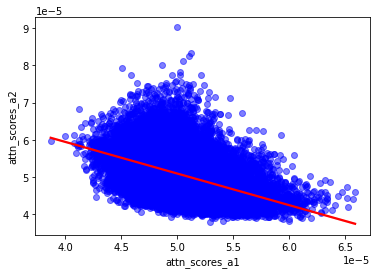

In [67]:
attn_scores_corelation = sns.regplot(data=df_test_pred_s, x="attn_scores_a1", y="attn_scores_a2",    scatter_kws = {"color": "blue", "alpha": 0.5},
            line_kws = {"color": "red"})
fig = attn_scores_corelation.get_figure()
fig.savefig(os.path.join(outputdir,  k ,"attn_scores_corelation.png")) 

In [ ]:
rom matplotlib_venn import venn2